### Испортируем всё необходимое

In [20]:
from newsapi import NewsApiClient
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
lemmatizer = WordNetLemmatizer()

#nltk.download('stopwords')

### Функция по очистке текста от всего, кроме слов и приведения к нижнему регистру

In [21]:
def clean_text(s:str):
    #s = re.sub('[^A-za-z0-9]+', ' ', s) # Оставляем только слова и цифры
    s = re.sub('[^A-za-z]+', ' ', s) # Оставляем только слова
    s = s.lower()
    return s

### Парсим Google news

#### Важные моменты:
1. Google news не позволяет через новое api одновременно задать страну, язык и временной диапазон, поэтому выбираем меньшее зло: язык и временной диапазон (вариант get_everything)
2. Google news не отдает через api полный текст новости (по крайне мере в бесплатном тарифе для разработчиков), поэтому берем description, в котором зачастую слов больше, чем в урезанном до 200 символов обрывке основной новости, да и значимых ключевиков, там очевидно больше (для чего и создается word cloud)
3. Google news в тарифе для разработчиков не выдает в одном запросе более 100 результатов, а так же на выдает результаты с индексом более 100 (например, если запросить 2-ю страницу при параметре page_size=100), поэтому парсить пришлось отдельно по дням.

In [31]:
api_key = 'b60299ddfa9743ffbaa4fa530d749c6c'
newsapi = NewsApiClient(api_key=api_key)

month_ago = (date.today() - relativedelta(months=1))
cur_date = date.today()
articles = []

# Google news выдает не более 100 результатов в одном api запросе по тарифу "developers"
# А за месяц примерно 3000 результатов, поэтому приходится парсить по дням

while month_ago <= cur_date:
    all_articles = newsapi.get_everything(qintitle='Russia',
                                          from_param=cur_date.strftime('%Y-%m-%d'),
                                          to=cur_date.strftime('%Y-%m-%d'),
                                          language='en',
                                          page_size=100)

    articles += all_articles['articles']
    cur_date = (cur_date - relativedelta(days=1))
    print('.', end=' ')
print('\nDone')

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Done


#### Вот столько новостей напарсили

In [32]:
len(articles)

2484

### Преобразуем в pandas DataFrame и очищаем от дублей и NaN значений по description
На всякий случай сохраняем DataFrame с новостями в оригинальном виде  
Смотрим сколько новостей осталось

In [33]:
df = pd.DataFrame(articles)
df.to_pickle('google_news.pkl') #Сохраним на всякий случай, т.к. Google дает  всего 100 запросов в день
# Удаляем дубли, убираем NaN значения
df = df.drop_duplicates(subset=['description']).dropna(subset=['description'])
df.shape[0]

2183

### Очищаем текст, разбиваем на слова, собираем слова в массив NumPy

In [34]:
words = np.concatenate(df['description'].apply(lambda s: clean_text(s).split()).values)

### Преобразуем массив NumPy в Pandas series, очищаем текст от стоп-слов, лемматизируем слова, приводим к верхнему регистру

In [35]:
words = pd.Series(list(words))
words = words[~words.isin(stopwords.words('english'))]
words = words.apply(lambda w: lemmatizer.lemmatize(w))
words = words.apply(lambda w: w.upper())

### Создаем словарь частотности из топ-50 слов, создаем word cloud, выводим, сохраняем

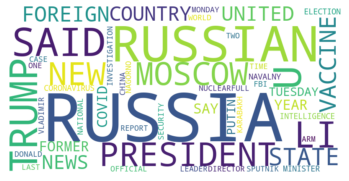

In [47]:
words_fr_dict = words.value_counts().head(50).to_dict()
wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(words_fr_dict)
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')
wordcloud.to_file("word_cloud.png");